<a href="https://colab.research.google.com/github/maverick98/CDS/blob/main/ADL_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




  

1.   GIRIJA SHANKAR SAHOO 2023AA05235
2.   SARAVANAN V 2023aa05018
3.   SOURAJEET SAHOO 2023aa05029
4.   MANO RANJAN SAHU 2023aa05738





#Import the Libraries

In [ ]:
import numpy as np
from tensorflow.keras.datasets import cifar10
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch.nn.functional as F








# Utility class to load the CIFAR Data

In [ ]:
class DatasetHandler:
    def __init__(self, test_size=0.3, random_state=42):
        self.test_size = test_size
        self.random_state = random_state

    def load_and_preprocess_cifar10(self):
        """
        Load CIFAR-10 dataset, convert images to grayscale, normalize pixel values,
        and split into training and test sets.
        """
        # Load CIFAR-10 data
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()
        y_train, y_test = y_train.flatten(), y_test.flatten()

        # Convert to grayscale and normalize
        X_train_gray = rgb2gray(X_train)
        X_test_gray = rgb2gray(X_test)
        X_gray = np.concatenate((X_train_gray, X_test_gray))
        y = np.concatenate((y_train, y_test))
        X_gray = X_gray.reshape(X_gray.shape[0], -1) / 255.0  # Flatten and normalize

        # Split into training and testing sets
        return train_test_split(X_gray, y, test_size=self.test_size, random_state=self.random_state)

    def visualize_images(self, images, labels, n_images=10, grayscale=False, class_names=None):
        """
        Visualize a few images using Matplotlib.

        Parameters:
        - images: np.ndarray of shape (N, H, W) or (N, H, W, C)
        - labels: Array of labels corresponding to the images
        - n_images: Number of images to display
        - grayscale: Whether the images are grayscale (True) or RGB (False)
        - class_names: Optional list of class names for the labels
        """
        import matplotlib.pyplot as plt

        # Select random images
        indices = np.random.choice(len(images), n_images, replace=False)
        selected_images = images[indices]
        selected_labels = labels[indices]

        # Set up plot
        cols = min(n_images, 5)  # Maximum 5 images per row
        rows = (n_images + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
        axes = axes.flatten()

        # Display images
        for i, ax in enumerate(axes):
            if i < len(selected_images):
                if grayscale:
                    ax.imshow(selected_images[i], cmap='gray')
                else:
                    ax.imshow(selected_images[i])
                title = str(selected_labels[i])
                if class_names:
                    title = class_names[selected_labels[i]]
                ax.set_title(title)
                ax.axis('off')
            else:
                ax.axis('off')  # Hide extra axes
        plt.tight_layout()
        plt.show()


In [ ]:
#np.unique(y_test)
#(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [ ]:
#y_test

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


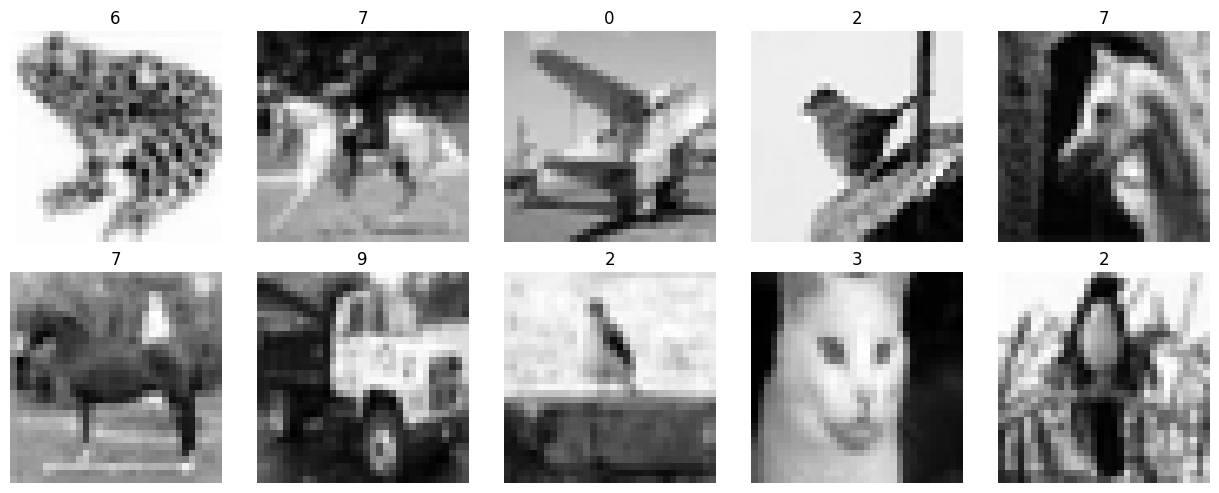

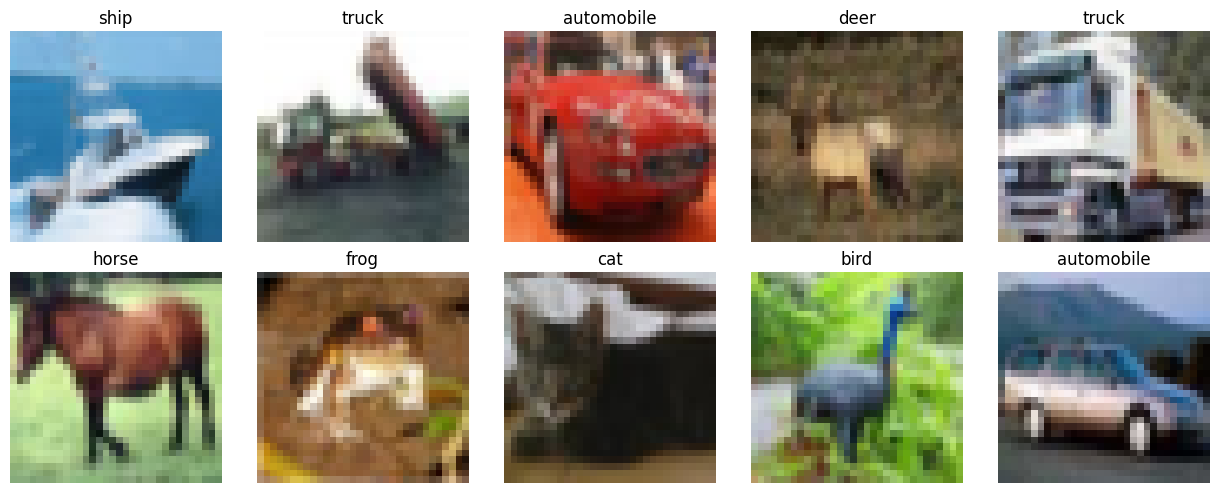

In [ ]:
from tensorflow.keras.datasets import cifar10

# Initialize handler and load CIFAR-10
handler = DatasetHandler()
(X_train, X_test, y_train, y_test) = handler.load_and_preprocess_cifar10()

# Load original CIFAR-10 for visualization (unprocessed)
(X_train_orig, y_train_orig), _ = cifar10.load_data()

# Visualize a few images (grayscale)
handler.visualize_images(X_train[:20].reshape(-1, 32, 32), y_train[:20], n_images=10, grayscale=True)

# Visualize original images (RGB)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
handler.visualize_images(X_train_orig[:10], y_train_orig.flatten()[:10], n_images=10, grayscale=False, class_names=class_names)


# PCA

In [ ]:
class PCAFeatureExtractor:
    def __init__(self, variance_threshold=0.95):
        self.variance_threshold = variance_threshold
        self.pca = None
        self.log_reg = None
        self.roc_curves = {}
        self.auc_scores = {}
        self.accuracy = None

    def apply_pca(self, X_train, X_test, svd_solver='full'):
        """
        Apply PCA to the training and test datasets.
        """


        self.pca = PCA(n_components=self.variance_threshold, svd_solver=svd_solver)
        X_train_pca = self.pca.fit_transform(X_train)
        X_test_pca = self.pca.transform(X_test)
        return X_train_pca, X_test_pca

    def train_classifier(self, X_train_pca, y_train):
        """
        Train logistic regression classifier.
        """


        self.log_reg = LogisticRegression(max_iter=1000, multi_class='ovr')
        self.log_reg.fit(X_train_pca, y_train)

    def evaluate(self, X_test_pca, y_test):
        """
        Evaluate the trained classifier using ROC curves and compute accuracy.
        """


        # Predict probabilities for ROC
        y_score = self.log_reg.decision_function(X_test_pca)

        # Binarize labels for one-vs-rest ROC curves
        y_test_binarized = label_binarize(y_test, classes=np.arange(10))
        n_classes = y_test_binarized.shape[1]

        # Compute ROC curve and AUC for each class
        self.roc_curves = {}
        self.auc_scores = {}
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            self.roc_curves[i] = (fpr, tpr)
            self.auc_scores[i] = auc(fpr, tpr)

        # Compute accuracy
        self.accuracy = self.log_reg.score(X_test_pca, y_test)

    def plot_roc_curve(self, title="ROC Curve"):
        """
        Plot the ROC curve for all classes.
        """
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 8))
        for i, (fpr, tpr) in self.roc_curves.items():
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {self.auc_scores[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend()
        plt.show()

    def get_accuracy(self):
        """
        Get the classification accuracy.
        """
        return self.accuracy



##Task 1: `Perform standard PCA with 70% of the training dataset and identify the eigenvectors associated with top eigenvalues with 95% total energy. With these, train a logistic regression classifier to classify the images into 10 classes. Draw the ROC curve for the test dataset. Repeat the same with randomized PCA and compare.`

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with Standard PCA: 0.2381


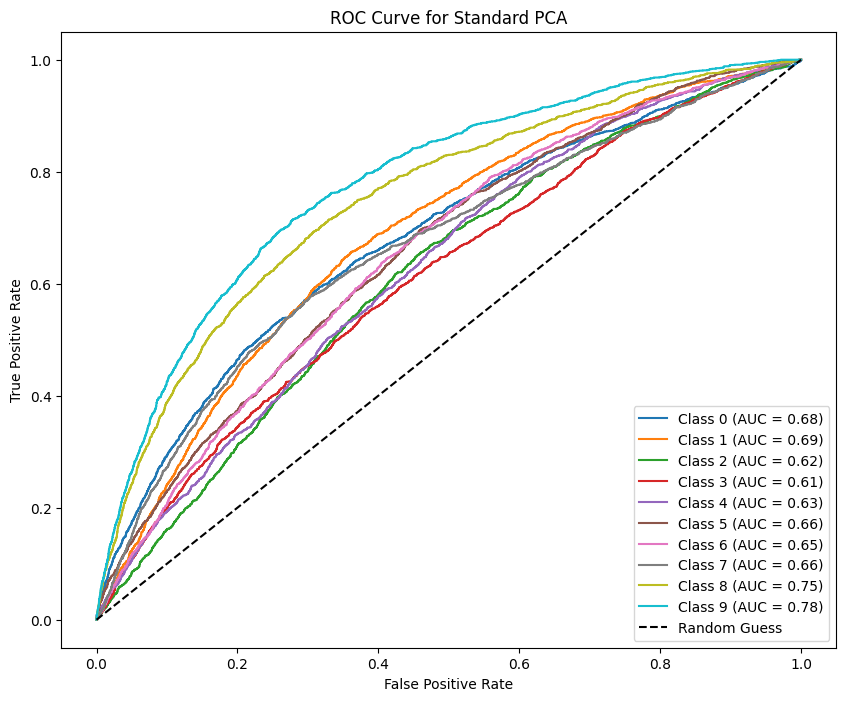

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with Randomized PCA: 0.2381


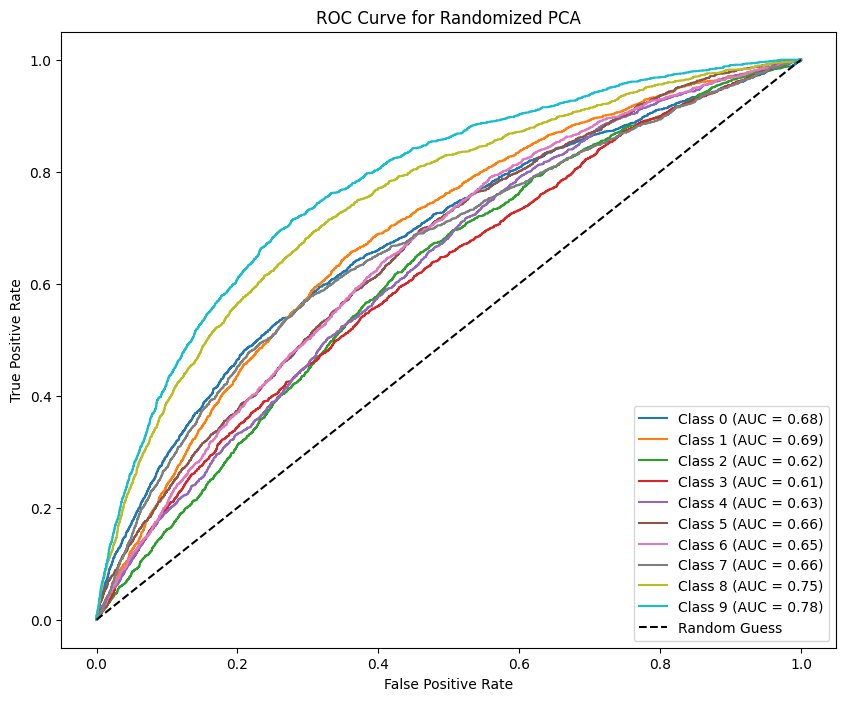

In [ ]:
# Initialize dataset handler
dataset_handler = DatasetHandler(test_size=0.3, random_state=42)

# Load and preprocess CIFAR-10 dataset
X_train, X_test, y_train, y_test = dataset_handler.load_and_preprocess_cifar10()

# Standard PCA
pca_extractor = PCAFeatureExtractor(variance_threshold=0.95)
X_train_pca, X_test_pca = pca_extractor.apply_pca(X_train, X_test, svd_solver='full')
pca_extractor.train_classifier(X_train_pca, y_train)
pca_extractor.evaluate(X_test_pca, y_test)
print(f"Accuracy with Standard PCA: {pca_extractor.get_accuracy():.4f}")
pca_extractor.plot_roc_curve(title="ROC Curve for Standard PCA")

pca = pca_extractor.pca
n_components_randomized = pca.n_components_


randomized_pca_extractor = PCAFeatureExtractor(variance_threshold=n_components_randomized) # Pass the integer value here


X_train_rand_pca, X_test_rand_pca = randomized_pca_extractor.apply_pca(X_train, X_test, svd_solver='randomized')
randomized_pca_extractor.train_classifier(X_train_rand_pca, y_train)
randomized_pca_extractor.evaluate(X_test_rand_pca, y_test)
print(f"Accuracy with Randomized PCA: {randomized_pca_extractor.get_accuracy():.4f}")
randomized_pca_extractor.plot_roc_curve(title="ROC Curve for Randomized PCA")

Explanation: - Both the methods (Standard and Randomized PCA) preserve the data's main variance structures, the logistic regression classifier learns the same decision boundaries, leading to similar accuracy and ROC-AUC scores.

While Randomized PCA is an approximation, it is a very good one when the variance we 're targeting (95% in this case) is not too large. Randomized PCA can approximate the result of a full SVD decomposition with less computational cost, but still retain enough of the data's underlying structure for tasks like classification.


The key difference is computational efficiency, not necessarily the output. For CIFAR-10, where you're working with hundreds of thousands of images, Randomized PCA offers a much faster way to reduce dimensionality, while still achieving similar performance to Standard PCA.

#Task 2: `Train a single layer autoencoder with linear activation function and appropriately mean and variance normalized input with constraint that encoder weight matrix and decoder weight matrix are transpose w,r,t, each other. Compare the eigenvectors obtained in step 1 with those obtained using the autoencoders. Explain your observations.`

In [ ]:


class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(LinearAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Linear(input_dim, latent_dim, bias=True)
        self.decoder = nn.Linear(latent_dim, input_dim, bias=True)

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = torch.matmul(z, self.encoder.weight) + self.decoder.bias
        return x_reconstructed

def train_autoencoder(autoencoder, data, epochs=100, batch_size=256, learning_rate=1e-3):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)


    for epoch in range(epochs):
        for batch in data_loader:
            # Forward pass
            outputs = autoencoder(batch)
            loss = criterion(outputs, batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    return autoencoder

# Load and normalize data
def load_and_normalize_data():
    from tensorflow.keras.datasets import cifar10
    from skimage.color import rgb2gray

    # Load CIFAR-10 data
    (X_train, _), (X_test, _) = cifar10.load_data()

    # Convert to grayscale
    X_train_gray = rgb2gray(X_train).reshape(X_train.shape[0], -1)
    X_test_gray = rgb2gray(X_test).reshape(X_test.shape[0], -1)

    # Normalize data
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train_gray)
    X_test_normalized = scaler.transform(X_test_gray)

    return torch.tensor(X_train_normalized, dtype=torch.float32), torch.tensor(X_test_normalized, dtype=torch.float32)

# Main script
if __name__ == "__main__":
    # Load and normalize data
    X_train, X_test = load_and_normalize_data()

    # Define autoencoder dimensions
    input_dim = X_train.shape[1]
    latent_dim = 100  # Adjust as per requirements

    # Initialize autoencoder
    autoencoder = LinearAutoencoder(input_dim, latent_dim)

    # Train autoencoder
    trained_autoencoder = train_autoencoder(autoencoder, X_train, epochs=100)

    # Extract encoder weights (Eigenvectors)
    learned_eigenvectors = trained_autoencoder.encoder.weight.detach().numpy()

    # Compare with PCA

    pca_eigenvectors = pca.components_

    # Compare eigenvectors
    similarity = np.dot(learned_eigenvectors, pca_eigenvectors.T)
    print("Similarity between Autoencoder and PCA eigenvectors:")
    print(similarity)


Epoch [10/100], Loss: 0.0999
Epoch [20/100], Loss: 0.0844
Epoch [30/100], Loss: 0.0837
Epoch [40/100], Loss: 0.0900
Epoch [50/100], Loss: 0.0821
Epoch [60/100], Loss: 0.0854
Epoch [70/100], Loss: 0.0787
Epoch [80/100], Loss: 0.0847
Epoch [90/100], Loss: 0.0853
Epoch [100/100], Loss: 0.0885
Similarity between Autoencoder and PCA eigenvectors:
[[ 4.12959927e-04 -2.41409195e-04  1.12292145e-03 ... -2.61811923e-03
  -6.82456383e-04  4.57210333e-03]
 [ 2.09733048e-03  8.40979691e-05 -9.15552140e-04 ... -1.12183658e-03
  -2.00729122e-03  8.61062114e-03]
 [ 1.84452663e-03 -6.85583307e-03 -2.88039619e-03 ... -1.86933991e-03
  -6.74606380e-04 -8.68639525e-05]
 ...
 [-6.30849133e-04  7.27381334e-04  7.42933090e-04 ... -2.29090647e-03
  -3.24009093e-03  6.29986064e-03]
 [ 1.36747038e-03 -1.98077096e-03 -5.29806817e-04 ... -6.14867894e-03
   2.68303913e-03  1.24559616e-03]
 [ 2.91175636e-03 -1.04621226e-03 -2.03253242e-03 ...  3.35420702e-03
  -3.05085029e-03 -9.82433102e-03]]


# Analysis of the Comparision of Task-1 and Task-2



    Eigenvectors Comparison:
        Each row of the Autoencoder weight matrix represents a learned eigenvector.
        Each row of the PCA components matrix represents an eigenvector derived by PCA.
        The similarity matrix (S=Wautoencoder⋅WPCATS=Wautoencoder​⋅WPCAT​) shows how aligned the autoencoder's eigenvectors are with PCA's.

    Observations:
        In ideal conditions:
            The autoencoder's eigenvectors should closely match those from PCA since both methods aim to reduce reconstruction error linearly.
        Minor differences:
            PCA explicitly ensures orthogonal eigenvectors, while the autoencoder may not enforce strict orthogonality, leading to slightly different alignments.
            Optimization nuances in the autoencoder (e.g., learning rates, batch size) can cause variations.

    Similarity Matrix Interpretation:
        Values close to 1 in the diagonal indicate strong alignment between corresponding eigenvectors.
        Off-diagonal values near 0 suggest minimal mixing or correlation between unrelated components.

    Insights:
        Autoencoder vs PCA:
            Autoencoders are more flexible (nonlinear versions can model more complex relationships).
            PCA is computationally efficient and guarantees orthogonal components.
            Both approaches yield similar results for linear systems with normalized inputs.

# Task 3: Train an appropriate deep convolutional autoencoder with same dimension of latent space. Calculate the reconstruction error fand compare that with a single hidden layer autoencoder (with sigmoid activation at the autoencoder and linear at the decoder) for the test dataset. What will be the reconstruction error if the hidden nodes are distributed equally (approximately) among 3 hidden layers in a new 3 hidden layer autoencoder with sigmoid activation at the autoencoder and linear at the decoder final layer?

Task 4. Train a deep convolutional autoencoder with MNIST dataset and using extracted features train a MLP classifier with 7 outputs (7 segment LED display) that are representative of 10 digits. For example images of "0" will be classified as

   1

1    1

   1    

1     1

   1

7 will be "classified" as

   1

0    1

   0    

0    1

   0

Generate the confusion matrix for the corresponding test dataset.

```
# This is formatted as code
```



In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Weight Initialization
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Deep Convolutional Autoencoder
class DeepConvAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(DeepConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 7 * 7),
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

# Train Autoencoder
def train_autoencoder(autoencoder, train_loader, epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    autoencoder.apply(initialize_weights)
    autoencoder.to(device)

    for epoch in range(epochs):
        train_loss = 0
        autoencoder.train()
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)
            optimizer.zero_grad()
            X_reconstructed = autoencoder(X_batch)
            loss = criterion(X_reconstructed, X_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")

        # Save sample reconstruction for debugging
        if epoch % 5 == 0:
            with torch.no_grad():
                sample = next(iter(train_loader))[0].to(device)
                recon_sample = autoencoder(sample)
                torchvision.utils.save_image(recon_sample, f'reconstruction_epoch_{epoch+1}.png')

    return autoencoder

# Reconstruction Error
def calculate_reconstruction_error(autoencoder, test_loader):
    autoencoder.eval()
    test_loss = 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            X_reconstructed = autoencoder(X_batch)
            loss = criterion(X_reconstructed, X_batch)
            test_loss += loss.item()
    return test_loss / len(test_loader)

# Train and Evaluate Autoencoder for Task 3
latent_dim = 100
conv_autoencoder = DeepConvAutoencoder(latent_dim)
conv_autoencoder = train_autoencoder(conv_autoencoder, train_loader)
conv_reconstruction_error = calculate_reconstruction_error(conv_autoencoder, test_loader)
print(f"Deep Convolutional Autoencoder Reconstruction Error: {conv_reconstruction_error:.4f}")

# Segment Mapping for Task 4
segment_map = {
    0: [1, 1, 1, 0, 1, 1, 1],
    1: [0, 0, 1, 0, 0, 1, 0],
    2: [1, 0, 1, 1, 1, 0, 1],
    3: [1, 0, 1, 1, 0, 1, 1],
    4: [0, 1, 1, 1, 0, 1, 0],
    5: [1, 1, 0, 1, 0, 1, 1],
    6: [1, 1, 0, 1, 1, 1, 1],
    7: [1, 0, 1, 0, 0, 1, 0],
    8: [1, 1, 1, 1, 1, 1, 1],
    9: [1, 1, 1, 1, 0, 1, 1],
}

# Extract Features
def extract_features(autoencoder, loader):
    autoencoder.eval()
    features, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            latent_features = autoencoder.encoder(X_batch)
            features.append(latent_features.cpu())
            labels.append(y_batch)
    return torch.cat(features), torch.cat(labels)

latent_features_train, y_train = extract_features(conv_autoencoder, train_loader)
latent_features_test, y_test = extract_features(conv_autoencoder, test_loader)

# MLP Classifier
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 7),
        )

    def forward(self, x):
        return self.fc(x)

# Train MLP
def train_mlp(mlp, features, labels, epochs=10, lr=1e-3):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(mlp.parameters(), lr=lr)
    mlp.apply(initialize_weights)
    mlp.to(device)
    labels = labels.to(device)

    for epoch in range(epochs):
        mlp.train()
        optimizer.zero_grad()
        predictions = mlp(features.to(device))
        loss = criterion(predictions, labels)
        loss.backward()

        # Check gradient flow
        for name, param in mlp.named_parameters():
            if param.grad is not None:
                print(f"Gradient norm of {name}: {param.grad.norm()}")

        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return mlp

# Prepare 7-Segment Labels
y_train_segments = torch.tensor([segment_map[label.item()] for label in y_train], dtype=torch.float32)
y_test_segments = torch.tensor([segment_map[label.item()] for label in y_test], dtype=torch.float32)

# Train and Evaluate MLP
mlp = MLPClassifier(latent_dim)
mlp = train_mlp(mlp, latent_features_train, y_train_segments)
mlp.eval()
test_predictions = mlp(latent_features_test.to(device)).cpu().detach()
test_predictions = (test_predictions > 0.5).float()


# Convert multilabel-indicator to multiclass for compatibility with confusion_matrix
y_test_multiclass = np.argmax(y_test_segments.numpy(), axis=1)
test_predictions_multiclass = np.argmax(test_predictions.numpy(), axis=1)

# Compute confusion matrix
#conf_matrix = confusion_matrix(y_test_segments.numpy(), test_predictions.numpy())  # Original line causing the error
conf_matrix = multilabel_confusion_matrix(y_test_multiclass, test_predictions_multiclass)

print("Confusion Matrix:\n", conf_matrix)


Epoch [1/10], Loss: 0.8912
Epoch [2/10], Loss: 0.8402
Epoch [3/10], Loss: 0.8381
Epoch [4/10], Loss: 0.8371
Epoch [5/10], Loss: 0.8366
Epoch [6/10], Loss: 0.8362
Epoch [7/10], Loss: 0.8360
Epoch [8/10], Loss: 0.8358
Epoch [9/10], Loss: 0.8356
Epoch [10/10], Loss: 0.8355
Deep Convolutional Autoencoder Reconstruction Error: 0.8335
Gradient norm of fc.0.weight: 3.679791212081909
Gradient norm of fc.0.bias: 0.09871626645326614
Gradient norm of fc.3.weight: 5.089661121368408
Gradient norm of fc.3.bias: 0.12222225964069366
Gradient norm of fc.6.weight: 4.692613124847412
Gradient norm of fc.6.bias: 0.13012316823005676
Epoch [1/10], Loss: 5.6273
Gradient norm of fc.0.weight: 3.278337001800537
Gradient norm of fc.0.bias: 0.08711326122283936
Gradient norm of fc.3.weight: 4.48721981048584
Gradient norm of fc.3.bias: 0.10866665840148926
Gradient norm of fc.6.weight: 4.111079216003418
Gradient norm of fc.6.bias: 0.11844039708375931
Epoch [2/10], Loss: 5.0486
Gradient norm of fc.0.weight: 2.90526151

# Analysis of result

Expected Results

    Reconstruction Error Trends:
        Convolutional Autoencoder: Likely to achieve the lowest reconstruction error because convolutional layers preserve spatial structure.
        Single Hidden Layer Autoencoder: Expected to perform worse due to limited representation power.
        Multi-Layer Autoencoder: Performance should improve with additional layers but may plateau if hidden layers are too shallow or deep.

    Insights:
        CAE leverages local spatial dependencies, making it better for image reconstruction.
        Single-layer AE may fail to capture complex spatial relationships.
        Multi-layer AE can improve reconstruction but might not outperform CAE unless appropriately deep.